<a href="https://colab.research.google.com/github/aitormorais/Qiskit/blob/main/qbit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qiskit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 16.0 MB/s eta 0:00:00


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import random
import qiskit

In [8]:
from qiskit_aer import AerSimulator

In [9]:
from qiskit import QuantumRegister, QuantumCircuit,Aer, execute,ClassicalRegister

In [ ]:
def generar_grafo(numero_ciudades):
    """
    Genera un grafo completo con un número dado de ciudades como nodos y asigna distancias aleatorias a cada par de nodos comprendidas entre el 1 y el 10.
    
    Parámetros
    ----------
    numero_ciudades : int
        El número de ciudades (nodos) para incluir en el grafo.
        
    Devoluciones
    ------------
    G : networkx.classes.graph.Graph
        Un objeto de grafo completo de NetworkX con 'numero_ciudades' nodos y distancias aleatorias asignadas a cada par de nodos.
        
    distancias : dict
        Un diccionario de NetworkX que mapea cada par de nodos a la 'distancia' entre ellos. Las claves del diccionario son tuplas de dos elementos que representan los pares de nodos, y los valores son las distancias aleatorias asignadas.
        
    Ejemplo
    -------
    >>> G, distancias = generar_grafo(5)
    >>> print(G.edges(data=True))
    [(0, 1, {'distancia': 3}), (0, 2, {'distancia': 7}), (0, 3, {'distancia': 2}), (0, 4, {'distancia': 6}), 
    (1, 2, {'distancia': 10}), (1, 3, {'distancia': 1}), (1, 4, {'distancia': 8}), (2, 3, {'distancia': 4}), 
    (2, 4, {'distancia': 5}), (3, 4, {'distancia': 9})]
    >>> print(distancias)
    {(0, 1): 3, (0, 2): 7, (0, 3): 2, (0, 4): 6, (1, 2): 10, (1, 3): 1, (1, 4): 8, (2, 3): 4, (2, 4): 5, (3, 4): 9}
    """
    # Crear un grafo completo con 'numero_ciudades' nodos
    G = nx.complete_graph(numero_ciudades)
    # Asignar una distancia aleatoria (entre 1 y 10) a cada par de nodos
    for (u, v) in G.edges():
        G.edges[u, v]['distancia'] = 1
    # Obtener un diccionario de las distancias entre cada par de nodos
    distancias = nx.get_edge_attributes(G, 'peso')
    return G, distancias


In [ ]:
def generate_hamiltonian_graph(num_nodes):
    """
    Genera un grafo Hamiltoniano no dirigido con un número dado de nodos y aristas adicionales aleatorias.

    Un grafo Hamiltoniano es un grafo que tiene un ciclo Hamiltoniano (un ciclo que visita cada nodo una vez).
    Esta función primero crea un ciclo que conecta todos los nodos, y luego agrega aristas adicionales de manera aleatoria.

    Parámetros
    ----------
    num_nodes : int
        El número de nodos para incluir en el grafo.

    Devoluciones
    ------------
    G : networkx.classes.graph.Graph
        Un objeto de grafo no dirigido de NetworkX con 'num_nodes' nodos, un ciclo Hamiltoniano,
        y aristas adicionales que se añaden aleatoriamente.

    Ejemplo
    -------
    >>> G = generate_hamiltonian_graph(5)
    >>> print(G.edges(data=True))
    [(0, 1, {'weight': 1.0}), (0, 4, {'weight': 1.0}), (1, 2, {'weight': 1.0}), 
    (2, 3, {'weight': 1.0}), (3, 4, {'weight': 1.0})]
    """
    # Crea un nuevo grafo no dirigido
    G = nx.Graph()

    # Agrega los nodos al grafo
    G.add_nodes_from(range(num_nodes))

    # Genera un camino Hamiltoniano
    for i in range(num_nodes - 1):
        G.add_edge(i, i + 1, weight=1.0)
    G.add_edge(num_nodes - 1, 0, weight=1.0)  # Cierra el ciclo para hacerlo Hamiltoniano

    # Agrega más aristas de manera aleatoria
    for i in range(num_nodes):
        for j in range(i + 2, num_nodes):
            if np.random.random() > 0.5:  # Añade la arista con una probabilidad del 50%
                G.add_edge(i, j, weight=1.0)

    return G


In [10]:
grafo = generate_hamiltonian_graph(6)

In [ ]:
def compute_cost(n, w, G, pos):
    """
    Calcula el costo de cada posible configuración de un sistema dado representado por un grafo y retorna el costo máximo y su configuración correspondiente.

    Parámetros
    ----------
    n : int
        El número de nodos en el grafo.
    w : numpy.ndarray
        Matriz de pesos de las aristas en el grafo.
    G : networkx.classes.graph.Graph
        Un objeto de grafo de NetworkX.
    pos : dict
        Un diccionario que mapea cada nodo a su posición en el grafo.

    Devoluciones
    -----------
    cost_dict : dict
        Un diccionario que mapea cada posible configuración del sistema a su costo asociado.
    best_cost_brute : int
        El costo máximo encontrado entre todas las configuraciones posibles.

    Ejemplo
    -------
    >>> cost_dict, best_cost_brute = compute_cost(n, w, G, pos)
    >>> print(best_cost_brute)
    15
    >>> print(cost_dict)
    {(0, 0, 0): 0, (0, 0, 1): 5, ..., (1, 1, 1): 15}
    """
    best_cost_brute = 0
    cost_dict = {}  # Diccionario para almacenar los casos y sus costos

    for b in range(2**n):
        x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
        cost = 0
        for i in range(n):
            for j in range(n):
                cost = cost + w[i, j] * x[i] * (1 - x[j])
        if best_cost_brute < cost:
            best_cost_brute = cost
            xbest_brute = x
        
        # Almacena el caso y el costo en el diccionario
        cost_dict[tuple(x)] = cost

    colors = ["r" if xbest_brute[i] == 0 else "c" for i in range(n)]
    draw_graph(G, colors, pos)

    return cost_dict, best_cost_brute


In [14]:
G = grafo
n = 6

In [33]:
def compute_weight_matrix(G, n):
    """
    Calcula la matriz de pesos a partir de un grafo dado.

    Parámetros
    ----------
    G : networkx.classes.graph.Graph
        Un objeto de grafo de NetworkX.
    n : int
        El número de nodos en el grafo.

    Devoluciones
    -----------
    w : numpy.ndarray
        Una matriz de 'n' por 'n' que representa los pesos de las aristas en el grafo. 
        Cada elemento w[i, j] es el peso de la arista entre los nodos i y j.

    Ejemplo
    -------
    >>> w = compute_weight_matrix(G, 5)
    >>> print(w)
    [[0. 1. 1. 1. 1.]
     [1. 0. 1. 1. 1.]
     [1. 1. 0. 1. 1.]
     [1. 1. 1. 0. 1.]
     [1. 1. 1. 1. 0.]]
    """
    # Calculando la matriz de pesos a partir del grafo aleatorio
    w = np.zeros([n, n])
    for i in range(n):
        for j in range(n):
            temp = G.get_edge_data(i, j, default=0)
            if temp != 0:
                w[i, j] = temp["weight"]
    return w


In [ ]:
cost_dict, best_cost_brute = compute_cost(n, w, G, pos)

In [11]:
def draw_graph(G, colors, pos):
    """
    Dibuja un grafo de NetworkX con nodos de colores y etiquetas de aristas.

    Parámetros
    ----------
    G : networkx.classes.graph.Graph
        Un objeto de grafo de NetworkX.
    colors : list
        Una lista de colores para los nodos. Cada nodo se dibuja con el color correspondiente de la lista.
    pos : dict
        Un diccionario que mapea cada nodo a su posición en el grafo.

    Ejemplo
    -------
    >>> draw_graph(G, ['red', 'red', 'cyan', 'cyan', 'cyan'], pos)
    """
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "peso")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


In [12]:
colors = ["r" for node in grafo.nodes()]
pos = nx.spring_layout(grafo)

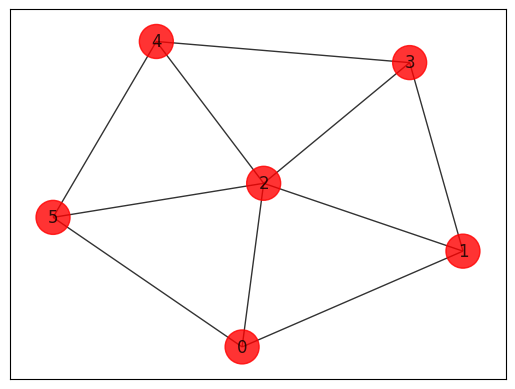

In [13]:
draw_graph(grafo, colors, pos)

In [34]:
def string_to_tuple(s):
    """
    Convierte una cadena de texto en una tupla, interpretando cada carácter como un número entero.

    Parámetros
    ----------
    s : str
        La cadena de texto a convertir. Se espera que cada carácter de la cadena sea un dígito decimal.

    Devoluciones
    -----------
    tuple
        Una tupla de enteros correspondiente a los caracteres de la cadena.

    Ejemplo
    -------
    >>> t = string_to_tuple("1234")
    >>> print(t)
    (1, 2, 3, 4)
    """
    return tuple(int(char) for char in s)



Qiskit


In [ ]:
def get_random_number(qc, qubit, reg):
    """
    Genera un número aleatorio (0 o 1) utilizando un circuito cuántico.

    Parámetros
    ----------
    qc : qiskit.circuit.quantumcircuit.QuantumCircuit
        El circuito cuántico en el que se realizará la operación.
    qubit : qiskit.circuit.quantumregister.QuantumRegister
        El registro cuántico que contiene los qubits en los que se realizará la operación.
    reg : qiskit.circuit.classicalregister.ClassicalRegister
        El registro clásico que se utilizará para la medición.

    Devoluciones
    -----------
    first_digit : int
        Un número aleatorio (0 o 1) generado a partir de la medida del estado del qubit.

    Ejemplo
    -------
    >>> qc = QuantumCircuit(1, 1)
    >>> qubit = QuantumRegister(1)
    >>> reg = ClassicalRegister(1)
    >>> random_number = get_random_number(qc, qubit, reg)
    >>> print(random_number)
    0
    """
    qc.h(qubit[0])
    qc.measure(qubit[0], reg[0])
    
    with qc.if_test((reg, 1)):
        qc.x(qubit[0])

    backend_sim = AerSimulator()
    reset_sim_job = backend_sim.run(qc, shots = 1)
    reset_sim_result = reset_sim_job.result()
    counts = reset_sim_result.get_counts(qc)

    key = list(counts.keys())[0]
    first_digit = int(key[0])  # Convierte el primer carácter de la clave a un entero
    return first_digit


In [35]:
def lanzar_circ_dinamico(qc,registro):
  # initialize the simulator
  backend_sim = AerSimulator()

  # run the circuit
  reset_sim_job = backend_sim.run(qc,backend_sim,shots = 1)
  # get the results
  reset_sim_result = reset_sim_job.result()
  # retrieve the bitstring counts
  counts = reset_sim_result.get_counts(qc)
  print(type(int(list(counts.keys())[0])))
  print("esto?",int(list(counts.keys())[0]))
  return int(list(counts.keys())[0])

In [20]:
def mutate_bit_random(qr,qc,probabilidad):
  """mutar bit random"""
  #mutar un qbit aleatorio
  if np.random.random() > probabilidad:
    qc.x(qr[np.random.randint(0,len(qr))])
  


In [21]:
def mutate_bit(qr,qc,bit):
  """dado un bit a mutar un qr y qc muta ese bit"""
  qc.x(qr[bit])

def mutate_multi_bit(qr,qc,probabilidad):#prob >0 and prob <1 a mas grande prob menos oportunidades de mutar
  for i in range(len(qr)):
     if np.random.random() > probabilidad:
      mutate_bit(qr,qc,i)

def mutate_bit_random(qr,qc,probabilidad):
  """mutar bit random"""
  #mutar un qbit aleatorio
  if np.random.random() > probabilidad:
    qc.x(qr[np.random.randint(0,len(qr))])

def mutate_exchange(qr,qc,probabilidad):
   if np.random.random() > probabilidad:
    numero0 = np.random.randint(0,len(qr))
    numero1  = np.random.randint(0,len(qr))
    if numero0 != numero1:
      qc.swap(qr[numero0], qr[numero1])





In [22]:
def mutate_exchange(qr,qc,probabilidad):
   if np.random.random() > probabilidad:
    numero0 = np.random.randint(0,len(qr))
    numero1  = np.random.randint(0,len(qr))
    if numero0 != numero1:
      qc.swap(qr[numero0], qr[numero1])




In [23]:
def puntos(qr):
  numero = np.random.randint(1,len(qr)-1) 
  num = np.random.randint(1,len(qr)-1)
  while numero == num:
    num = np.random.randint(1,len(qr)-1)
  if num > numero:
    return numero,num
  else:
    return num,numero


In [24]:
def escribir(qc,qreg, bin_string):

    """funcion que sirve tanto para escribir como para 'resetear' un registro, si quieres escribir sin tener que poner tu manualmente las puertas not en bin_string pon el numero que quieras.
    Si por el contrario quieres resetear tu resultado de un registro cuantico bin_string tiene que ser el contenido actual del registro cuantico

    """
    # Creamos un QuantumCircuit usando el QuantumRegister
    #qc = QuantumCircuit(qreg)
    
    # Verificamos si el tamaño del QuantumRegister es suficiente para el string binario
    if qreg.size < len(bin_string):
        raise ValueError("El QuantumRegister no es suficientemente grande para el string binario")

    # Recuerda que Qiskit usa notación little-endian, por lo que necesitamos invertir el string
    bin_string = bin_string[::-1]
    
    # Aplicamos la puerta X (NOT) a los qubits correspondientes
    for i, bit in enumerate(bin_string):
      if bit == '1':
          qc.x(i)

In [25]:
def create_qc(number_quantum_reg,qubits,number_classic_reg,bits):
  """facilita el crear circuitos cuanticos si quieres poner ancillas aconesjo hacerlo manualmente partiendo desde aqui"""
  
  # Create quantum registers
  qregs = [QuantumRegister(qubits, name=f'q{i}') for i in range(number_quantum_reg)]
  ancilla = QuantumRegister(1, name='ancilla')

  # Create classical registers
  cregs = [ClassicalRegister(bits, name=f'c{i}') for i in range(number_classic_reg)]
  cr_ancilla = ClassicalRegister(1, name='cr_ancilla')

  # Create a quantum circuit
  return QuantumCircuit(*qregs, ancilla, *cregs, cr_ancilla)


In [26]:
def lanzar_dinamico(circuito):
  backend_sim = AerSimulator()

  # run the circuit
  reset_sim_job = backend_sim.run(circuito,shots = 1)
  # get the results
  reset_sim_result = reset_sim_job.result()
  # retrieve the bitstring counts
  
  return reset_sim_result.get_counts()


In [27]:
def valores_hijos(resultados):
  "suponiendo que solo tenemos dos creg"
  for key in resultados.keys():
    return string_to_tuple(key.split(' ')[2]),string_to_tuple(key.split(' ')[1])
    #hijo1 = key.split(' ')[1]#cr[1]
    #hijo0 = key.split(' ')[2]#cr[0]  # split the string by spaces and get the second element

In [28]:
def tuple_to_string(t):
    return ''.join(str(num) for num in t)


In [29]:
def mutate_bit(qr,qc,bit):
  """dado un bit a mutar un qr y qc muta ese bit"""
  qc.x(qr[bit])

def mutate_multi_bit(qr,qc,probabilidad):#prob >0 and prob <1 a mas grande prob menos oportunidades de mutar
  for i in range(len(qr)):
     if np.random.random() > probabilidad:
      mutate_bit(qr,qc,i)

def mutate_bit_random(qr,qc,probabilidad):
  """mutar bit random"""
  #mutar un qbit aleatorio
  if np.random.random() > probabilidad:
    qc.x(qr[np.random.randint(0,len(qr))])

def mutate_exchange(qr,qc,probabilidad):
   if np.random.random() > probabilidad:
    numero0 = np.random.randint(0,len(qr))
    numero1  = np.random.randint(0,len(qr))
    if numero0 != numero1:
      qc.swap(qr[numero0], qr[numero1])

In [30]:
def qga(number_quantum_reg,qubits,number_classic_reg,bits,cost_dict,probabilidad,mejor):
  "algoritmo genetico cuantico"
  #qc = create_qc(number_quantum_reg,qubits,number_classic_reg,bits)
  # Create quantum registers
  qregs = [QuantumRegister(qubits, name=f'q{i}') for i in range(number_quantum_reg)]
  ancilla = QuantumRegister(1, name='ancilla')

  # Create classical registers
  cregs = [ClassicalRegister(bits, name=f'c{i}') for i in range(number_classic_reg)]
  cr_ancilla = ClassicalRegister(1, name='cr_ancilla')
  qc = QuantumCircuit(*qregs, ancilla, *cregs, cr_ancilla)
  generation = 0 
  best = False
  result = ''
  #case = (0, 1, 0, 0, 0, 1) cost = 5.0 emepzaremos con este reg como padre y el segundo reg en superposicion
  inicial = (0, 1, 0, 0, 0, 1)
  for i in range(qc.qregs[1].size):
    qc.h(qc.qregs[1][i])
  #crear_hijo(base,hasta,qubits,qc.qregs[0],qc.qregs[1],qc.qregs[2],qc,qc.ancilla,qc.cr_ancilla)#usando al padre
  #crear_hijo(base,hasta,qubits,qc.qregs[1],qc.qregs[0],qc.qregs[3],qc,qc.ancilla,qc.cr_ancilla)#usando a la madre
  while generation <10 or best == True:
    crear_hijo(*puntos(qc.qregs[0]),qubits,qc.qregs[0],qc.qregs[1],qc.qregs[2],qc,ancilla,cr_ancilla)#usando al padre qc.qregs[-2]  # -2 since ancilla is the second last element added to qregs
    crear_hijo(*puntos(qc.qregs[0]),qubits,qc.qregs[1],qc.qregs[0],qc.qregs[3],qc,ancilla,cr_ancilla)#usando a la madre
    for i in range(qubits):

      qc.measure(qc.qregs[2][i],qc.cregs[0][i])

      qc.measure(qc.qregs[3][i],qc.cregs[1][i])

    hijo0,hijo1 = valores_hijos(lanzar_dinamico(qc))
    print("recien_crea2 hijo0: ",hijo0)
    print("recien_crea2: ",hijo1)
    if cost_dict[inicial] < cost_dict[hijo0] or cost_dict[inicial] < cost_dict[hijo1] or hijo0 == mejor or hijo1 == mejor:
      if hijo0 == mejor:
        result = hijo0
        best = True 
      if hijo1 == mejor:
        result = hijo1
        best = True 
      escribir(qc,qc.qregs[0],tuple_to_string(inicial))#borramos la info del padre
        
      if cost_dict[inicial] < cost_dict[hijo0]:

        escribir(qc,qc.qregs[0],tuple_to_string(hijo0))
        inicial = hijo0
        result = hijo0

      if cost_dict[inicial] < cost_dict[hijo1]:
        escribir(qc,qc.qregs[0],tuple_to_string(hijo1))
        inicial = hijo1
        result = hijo1
      print("hijo0: ",hijo0)
      print("hijo1: ",hijo1)
    
    else:
      print("muta2")
      cual = np.random.randint(0, 4)#aleatorio cual de las 4 mutaciones
      functions = {
          0: lambda: mutate_bit(qc.qregs[0], qc, np.random.randint(0, len(qc.qregs[0]))),
          1: lambda: mutate_multi_bit(qc.qregs[0], qc, probabilidad),
          2: lambda: mutate_bit_random(qc.qregs[0], qc, probabilidad),
          3: lambda: mutate_exchange(qc.qregs[0], qc, probabilidad)
      }
      functions[cual]()
      print("hijo0: ",hijo0)
      print("hijo1: ",hijo1)
    
    print("inicial: ",inicial)
    print("hijo0: ",hijo0)
    print("hijo1: ",hijo1)
    generation+=1
    print(generation)
  return result

  #ahora tenemos que evaluar a los hijos, en caso de que sean mejores que los padres sobrescribrir
  # en caso contrario aplicar mutacion a los hijos y volver a evaluar, si nada acabar iteracion




In [39]:
result = qga(4,6,2,6,cost_dict,0.6,9)

recien_crea2 hijo0:  (0, 1, 0, 0, 0, 0)
recien_crea2:  (0, 0, 0, 1, 1, 0)
muta2
hijo0:  (0, 1, 0, 0, 0, 0)
hijo1:  (0, 0, 0, 1, 1, 0)
inicial:  (0, 1, 0, 0, 0, 1)
hijo0:  (0, 1, 0, 0, 0, 0)
hijo1:  (0, 0, 0, 1, 1, 0)
1
recien_crea2 hijo0:  (1, 0, 0, 0, 0, 0)
recien_crea2:  (1, 0, 0, 0, 1, 0)
muta2
hijo0:  (1, 0, 0, 0, 0, 0)
hijo1:  (1, 0, 0, 0, 1, 0)
inicial:  (0, 1, 0, 0, 0, 1)
hijo0:  (1, 0, 0, 0, 0, 0)
hijo1:  (1, 0, 0, 0, 1, 0)
2


KeyboardInterrupt: ignored

In [ ]:
def int_bit(numero, longitud):
    # Comprobamos si el número es demasiado grande para la cantidad de bits especificada.
    if numero > 2 ** longitud:
        raise ValueError(f"El número {numero} es demasiado grande para representarse con {longitud} bits")

    # Convertimos el número a binario con 'bin()', y lo convertimos a string con 'str()'.
    # La función 'bin()' retorna un string que comienza con '0b' para indicar que es un número binario,
    # así que utilizamos el slicing '[2:]' para eliminar estos caracteres.
    binary_str = str(bin(numero))[2:]

    # Ahora rellenamos con ceros a la izquierda hasta tener la longitud deseada usando 'zfill()'.
    return binary_str.zfill(longitud)




In [ ]:
def evaluar_resultados(qc,hijo1,hijo2,cr_hijo1,cr_hijo2,i,dic_qga,padre,madre,dic_mirar):
  """funcion que se encarga de 'obtener' los resultados"""
  binario = format(i,'06b')
  
  if dic_qga[binario]>dic_qga[padre]or dic_qga[binario]>dic_qga[madre]:
    if dic_qga[binario]>dic_qga[padre]:
      
      for qubit in padre:
        qc.reset(qubit)

      del dic_qga[padre]
      dic_qga[binario] = dic_mirar[binario]#funcio por implementar que buscara el valor en la lista
    if dic_qga[binario]>dic_qga[madre]:#faltaria asegurarse de no duplicar el padre y madre
      dic_qga[binario] = dic_mirar[binario]
      del dic_qga[madre]





In [ ]:
def get_keys_with_highest_values(d, n):
    sorted_items = sorted(d.items(), key=lambda item: item[1], reverse=True)
    top_n_items = sorted_items[:n]
    top_n_keys = [item[0] for item in top_n_items]
    return top_n_keys


ANCILLAS

OPENQASM 2.0;
include "qelib1.inc";
qreg q[4];
//x q[0];
//x q[1];
cx q[0], q[1];
ccx q[0], q[1], q[3];
ccx q[3], q[2], q[1];
ccx q[1], q[3], q[0];
ccx q[1], q[2], q[3];
cx q[1], q[2];
cx q[0], q[1];
cx q[1], q[2];
cx q[1], q[3];
ccx q[3], q[2], q[0];
cx q[1], q[2];
cx q[1], q[3];

In [ ]:
from qiskit import QuantumRegister, QuantumCircuit, Aer, execute, ClassicalRegister

In [38]:
def padre_hijo(circuit,qreg_padre,qreg_hijo,qreg_ancilla,cr_ancilla,base,hasta):
    for i in range(base, hasta):
      circuit.cx(qreg_padre[i], qreg_hijo[i])
      circuit.x(qreg_padre[i])
      circuit.x(qreg_hijo[i])
      circuit.ccx(qreg_padre[i], qreg_hijo[i], qreg_ancilla[0])
      circuit.x(qreg_padre[i])
      circuit.x(qreg_hijo[i])
      circuit.cx(qreg_ancilla[0], qreg_hijo[i])
      circuit.x(qreg_hijo[i])
      circuit.x(qreg_ancilla[0])
      circuit.ccx(qreg_padre[i], qreg_ancilla[0], qreg_hijo[i])
      circuit.ccx(qreg_padre[i], qreg_hijo[i], qreg_ancilla[0])
      circuit.ccx(qreg_padre[i], qreg_ancilla[0], qreg_hijo[i])
      circuit.measure(qreg_ancilla[0], cr_ancilla[0])
      with circuit.if_test((cr_ancilla[0],1)):
        circuit.x(qreg_ancilla[0])




       

In [37]:
def crear_hijo(base,hasta,maximo,qreg_padre,qreg_madre,qreg_hijo,qc,qreg_ancilla,cr_ancilla):
  #inicio aleatorio padre o madre
  if get_random_number(qc,qreg_ancilla,cr_ancilla) == 0:#padre editar para que el circuito original incluya un genrador de numeros
    padre_hijo(qc,qreg_padre,qreg_hijo,qreg_ancilla,cr_ancilla,0,base)
  else:
    padre_hijo(qc,qreg_madre,qreg_hijo,qreg_ancilla,cr_ancilla,0,base)

  padre_hijo(qc,qreg_padre,qreg_hijo,qreg_ancilla,cr_ancilla,base,hasta)#medio
  #padre_hijo(circuito, padre, hijo,0,hasta+1,ancilla)

  #padre_hijo(qc, padre, hijo, ancilla,base+1,hasta+1)
  padre_hijo(qc,qreg_madre,qreg_hijo,qreg_ancilla,cr_ancilla,hasta,len(qreg_padre))#fin
  #padre_hijo(circuito, madre, hijo,hasta+1,maximo,ancilla)

In [ ]:
crear_hijo(base,hasta,len(qc),qr1,qr2,qr3,qc,ancilla,cr)

In [ ]:
for i in range(len(qr3)):
  qc.measure(qr3[i],cr_hijo[i])

In [ ]:


# initialize the simulator
backend_sim = AerSimulator()

# run the circuit
reset_sim_job = backend_sim.run(qc,backend_sim,shots = 1)
# get the results
reset_sim_result = reset_sim_job.result()
# retrieve the bitstring counts
reset_sim_counts = reset_sim_result.get_counts()

print(f"Counts: {reset_sim_counts}")

Counts: {'001110 0': 511, '000110 0': 513}


In [ ]:
simulator = Aer.get_backend('qasm_simulator')
job = execute(qc, simulator, shots=1000000)
result = job.result()
counts = result.get_counts(qc)

In [ ]:
counts

{'0': 1000000}

In [ ]:
qc.draw()

┌───┐               ┌───┐     ┌─┐
q154_0: ┤ H ├──■────■───────┤ X ├─────┤M├
        ├───┤┌─┴─┐  │       └─┬─┘     └╥┘
q154_1: ┤ H ├┤ X ├──■────■────■────■───╫─
        ├───┤└───┘┌─┴─┐  │    │    │   ║ 
q154_2: ┤ H ├─────┤ X ├──■────┼────■───╫─
        ├───┤     └───┘┌─┴─┐  │  ┌─┴─┐ ║ 
q154_3: ┤ H ├──────────┤ X ├──■──┤ X ├─╫─
        └───┘          └───┘     └───┘ ║ 
  c6: 1/═══════════════════════════════╩═
                                       0

In [ ]:
# Crear los registros cuánticos
qr = QuantumRegister(6, name = "qr0")
qr1 = QuantumRegister(6, name = "qr1")
qr2 = QuantumRegister(6, name = "qr2")
qr3 = QuantumRegister(6, name = "qr3")
ancilla = QuantumRegister(4, name = "ancilla")

# Crear los registros clásicos correspondientes
cr = ClassicalRegister(6, name = "cr0")
cr1 = ClassicalRegister(6, name = "cr1")
cr2 = ClassicalRegister(6, name = "cr2")
cr3 = ClassicalRegister(6, name = "cr3")


# Crear el circuito cuántico
qc = QuantumCircuit(qr, qr1, qr2, qr3,ancilla, cr, cr1, cr2, cr3)

state_qr = '111111'
for i in range(6):
    if state_qr[i] == '1':
        qc.x(qr[5-i])  # Aquí 5-i se utiliza debido a la convención de ordenamiento de qubits de Qiskit.


# Inicializar qr1 a |001101⟩
state_qr1 = '001100'
for i in range(6):
    if state_qr1[i] == '1':
        qc.x(qr1[5-i]) 

# Aplicar la puerta de Hadamard a todos los qubits de qr2 y qr3
"""for i in range(6):
  qc.h(qr2[i])
  qc.h(qr3[i])"""

#ancilla = QuantumRegister(1,name = "ancilla")

# Crear el circuito cuántico

base, hasta = puntos(qr3)

print("base: ",base)
print("hasta:", hasta)
# Aplicar las operaciones
#"""
crear_hijo(base,hasta,len(qr),qr,qr1,qr2,qc,ancilla)
#ancilla = QuantumRegister(1, name = "ancilla")
mover_ancillas(ancilla,qc)
crear_hijo(base,hasta,len(qr),qr1,qr,qr3,qc,ancilla)#"""

for i in range(6):
  qc.measure(qr[i], cr[i])
  qc.measure(qr1[i], cr1[i])
  qc.measure(qr2[i], cr2[i])
  qc.measure(qr3[i], cr3[i])

#padre_hijo(qc, qr1, qr2, ancilla,hasta+1,6)

# Imprimir el circuito
#print(qc)


In [ ]:
backend = Aer.get_backend("qasm_simulator")
trabajo = execute(qc,backend,shots = 1024)
resultado = trabajo.result()
contar_estados = resultado.get_counts(qc)

In [ ]:

simulator = Aer.get_backend('qasm_simulator')
job = execute(qc, simulator, shots=4)
result = job.result()
counts = result.get_counts(qc)


In [ ]:
counts

{'010011 100000 110011 000000': 4}

Counts for qr:  {' 100000': 4}
Counts for qr1:  {'101100': 4}
Counts for qr2:  {'100000 ': 4}
Counts for qr3:  {'000000 ': 4}


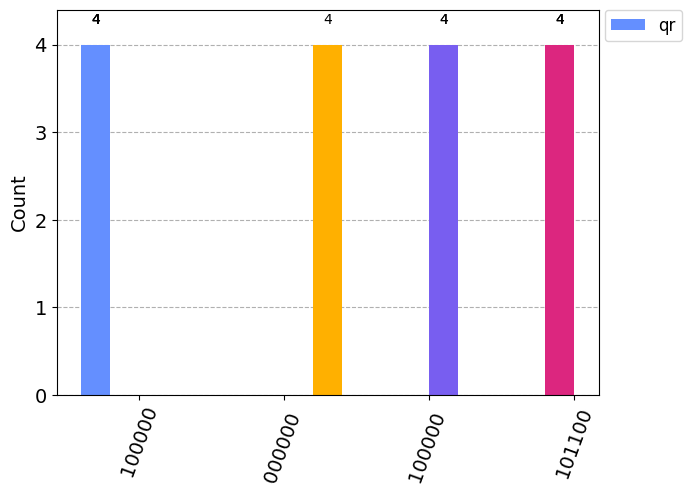

In [ ]:

# Separar las cuentas de los cuatro registros
counts_qr = {key[20:]: counts[key] for key in counts.keys()}
counts_qr1 = {key[14:20]: counts[key] for key in counts.keys()}
counts_qr2 = {key[7:14]: counts[key] for key in counts.keys()}
counts_qr3 = {key[:7]: counts[key] for key in counts.keys()}

# Imprimir las cuentas
print("Counts for qr: ", counts_qr)#azul claro
print("Counts for qr1: ", counts_qr1)#morado
print("Counts for qr2: ", counts_qr2)
print("Counts for qr3: ", counts_qr3)

# Dibujar los histogramas de las cuentas
plot_histogram([counts_qr, counts_qr1, counts_qr2, counts_qr3], legend=['qr', 'qr1', 'qr2', 'qr3'])

In [ ]:
padre_hijo(qc, qr1, qr2, ancilla,hasta+1,6)

5


In [ ]:
qc.draw()

In [ ]:
from qiskit import QuantumCircuit

# Inicialización
qc = QuantumCircuit(3)

# Prueba: Cambia |10⟩ a |11⟩
qc.x(0) # primer qubit a |1⟩
# el segundo qubit está en |0⟩

# Implementación del circuito
qc.cx(0, 1) # Para |10⟩ => |11⟩
qc.x(0)
qc.x(1) # Prepara los qubits para la siguiente operación
qc.ccx(0, 1, 2) # Marca |00⟩ en el ancilla
qc.x(1) # Aplica NOT en q[1] si el ancilla está en |1⟩
qc.x(0)
qc.cx(2, 1)
qc.x(1)
qc.x(2) # Devuelve los qubits y el ancilla a sus estados originales

qc.barrier()

# Restablece el qubit ancilla
qc.ccx(0, 2, 1)
qc.ccx(0, 1, 2)
qc.ccx(0, 2, 1)
qc.reset(2)

print(qc)


     ┌───┐     ┌───┐     ┌───┐           ░                     
q_0: ┤ X ├──■──┤ X ├──■──┤ X ├───────────░───■────■────■───────
     └───┘┌─┴─┐├───┤  │  ├───┤┌───┐┌───┐ ░ ┌─┴─┐  │  ┌─┴─┐     
q_1: ─────┤ X ├┤ X ├──■──┤ X ├┤ X ├┤ X ├─░─┤ X ├──■──┤ X ├─────
          └───┘└───┘┌─┴─┐└───┘└─┬─┘├───┤ ░ └─┬─┘┌─┴─┐└─┬─┘     
q_2: ───────────────┤ X ├───────■──┤ X ├─░───■──┤ X ├──■───|0>─
                    └───┘          └───┘ ░      └───┘          
